In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Generating summary figures for BacSC datasets

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau
import pickle as pkl

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Preprocessing
### Read data

In [27]:
dataset_name = "Pseudomonas_combined_PB"

data_path = "../../data/MOBA_scRNAseq"
data_gene = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")
data_gene_cluster = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed_cluster.h5ad")

result_path = "S2S3_combined"
with open(result_path + "_scdeed/scdeed_rel_scores.pkl", "rb") as f:
    rel_scores = pkl.load(f)
with open(result_path + "_scdeed/scdeed_null_rel_scores.pkl", "rb") as f:
    null_rel_scores = pkl.load(f)
with open(result_path + "_scdeed/scdeed_reliabilities.pkl", "rb") as f:
    reliabilities = pkl.load(f)
    
mod_df = pd.read_csv(result_path + "_clustering/modularities.csv")
mod_df_wide = pd.read_csv(result_path + "_clustering/modularities_wide.csv")

data_null_gen = sc.read_h5ad(data_path + "/null_data_S2S3_combined.h5ad")

figure_path = data_path + "/S2S3_combined_figures"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

## Single plots
### UMAPs

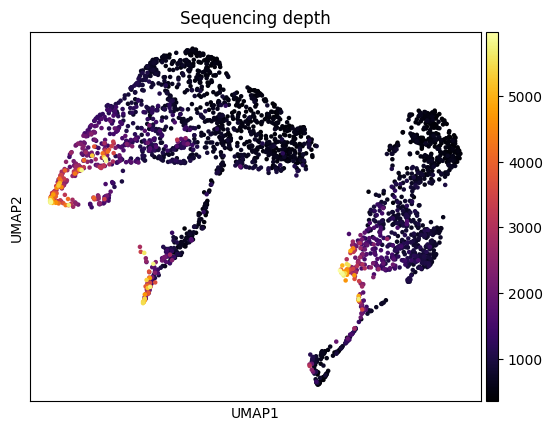

In [46]:
umap_seq_depth = sc.pl.umap(data_gene, color="total_counts", show=False, title="Sequencing depth", cmap="inferno")
plt.savefig(figure_path + "/umap_depth.svg", format="svg")
plt.show()

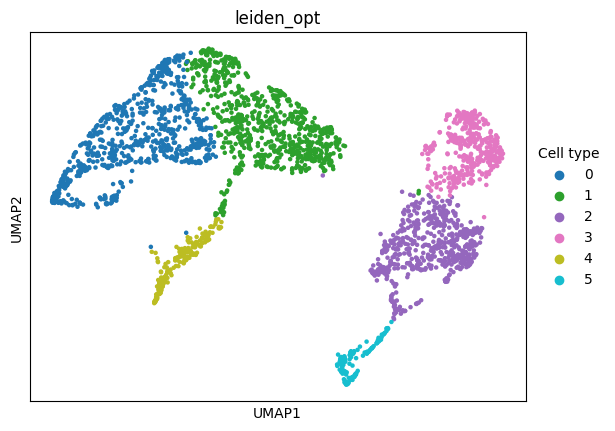

In [6]:
umap_clusters = sc.pl.umap(data_gene, color="leiden_opt", show=False, palette="tab10")
umap_clusters.axes.legend_.set_title("Cell type")
plt.savefig(figure_path + "/umap_clusters.svg", format="svg")
plt.show()

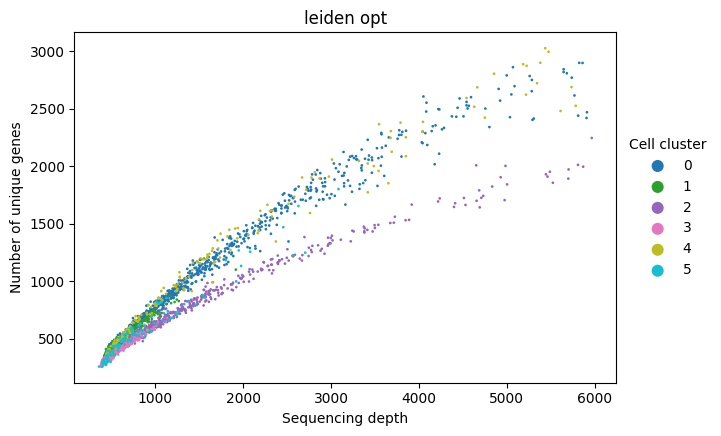

In [7]:
seq_depth_scatter = sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt", palette="tab10")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
seq_depth_scatter.legend_.set_title("Cell cluster")

plt.savefig(figure_path + "/seq_depth_scatter.svg", format="svg")

plt.show()

In [49]:
data_gene.obs["Condition"] = ["Balanced" if x == "S3" else "Low-iron" for x in data_gene.obs["Sample"]]


In [54]:
data_gene.uns

{'BacSC_params': {'k_opt': 4,
  'min_dist_opt': 0.1,
  'n_neighbors_opt': 45,
  'res_opt': 0.21},
 'Sample_colors': array(['#1f77b4', '#ff7f0e'], dtype=object),
 'embedding_reliability_colors': ['#17becfff', '#1f77b4ff', '#d62728ff'],
 'leiden_opt': {'params': {'n_iterations': -1,
   'random_state': 3564,
   'resolution': 0.21}},
 'leiden_opt_colors': ['#1f77b4',
  '#2ca02c',
  '#9467bd',
  '#e377c2',
  '#bcbd22',
  '#17becf'],
 'neighbors': {'connectivities_key': 'connectivities',
  'distances_key': 'distances',
  'params': {'method': 'umap',
   'metric': 'euclidean',
   'n_neighbors': 45,
   'n_pcs': 4,
   'random_state': 0}},
 'pca': {'params': {'use_highly_variable': False, 'zero_center': True},
  'variance': array([86.73339266, 24.30964895, 20.59260846, 14.16025442,  9.36367605,
          8.64361985,  5.98930173,  5.93414155,  5.89088385,  5.83686652,
          5.80564766,  5.79604629,  5.74898008,  5.71777858,  5.70512623,
          5.68845374,  5.67499156,  5.6634987 ,  5.635258

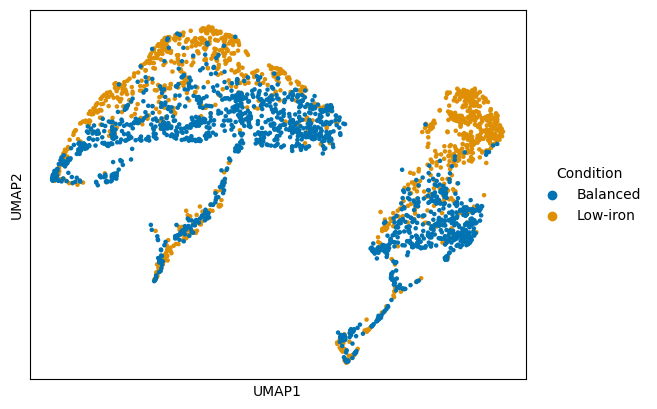

In [60]:
pal = [sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[1]]
umap_sample = sc.pl.umap(data_gene, color="Condition", show=False, palette=pal, title="")
umap_sample.axes.legend_.set_title("Condition")
plt.show()

### Violin plots

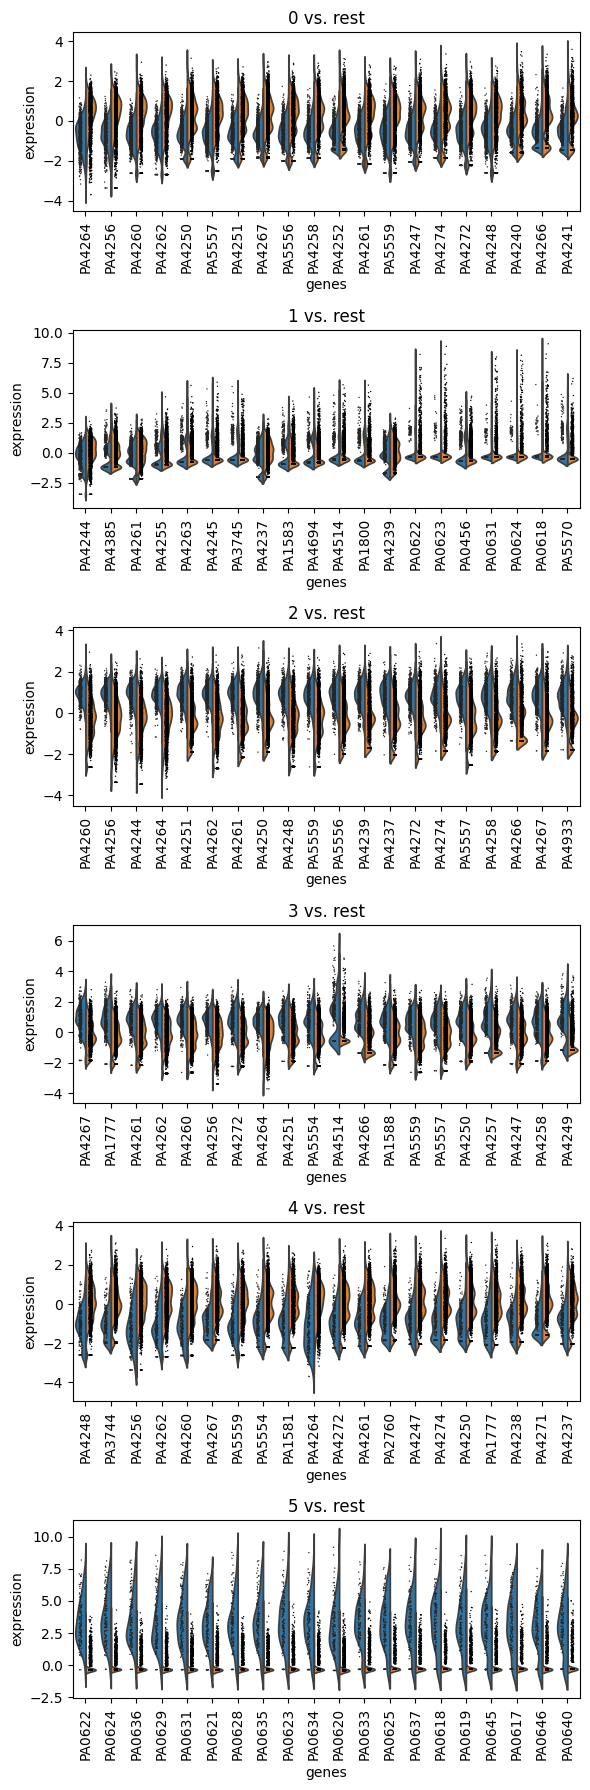

In [8]:
n_genes = 20
clusters = data_gene.obs["leiden_opt"].unique().tolist()
clusters.sort()

fig, ax = plt.subplots(len(clusters), 1, figsize=(6, 3*len(clusters)))

i = 0
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    violins = sc.pl.rank_genes_groups_violin(data_gene_cluster, gene_names=plot_genes, key="ClusterDE_results", groups=c, ax=ax[i], show=False)
    
    i += 1
    
plt.tight_layout()
plt.savefig(figure_path + "/violin_plots.svg", format="svg")

plt.show()

### Heatmap of highly differential genes

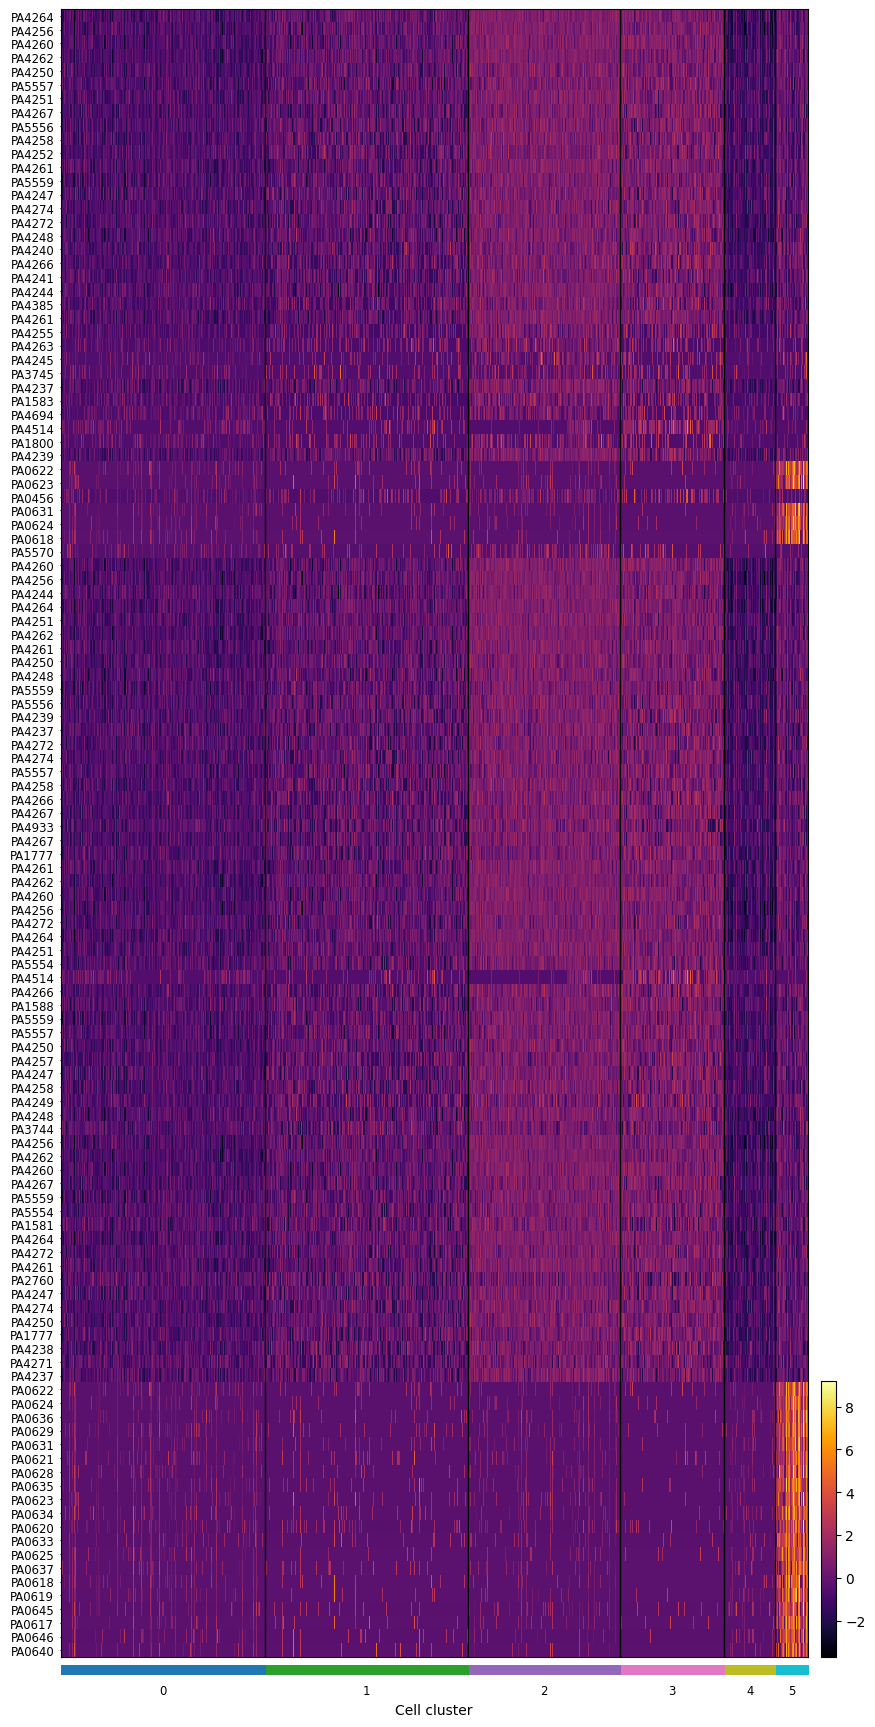

In [9]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes

heatmap_plot = sc.pl.heatmap(data_gene_cluster, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True, show=False, cmap="inferno")
heatmap_plot["groupby_ax"].set(xlabel="Cell cluster")

plt.savefig(figure_path + "/heatmap.svg", format="svg")

plt.show()

### Volcano plots

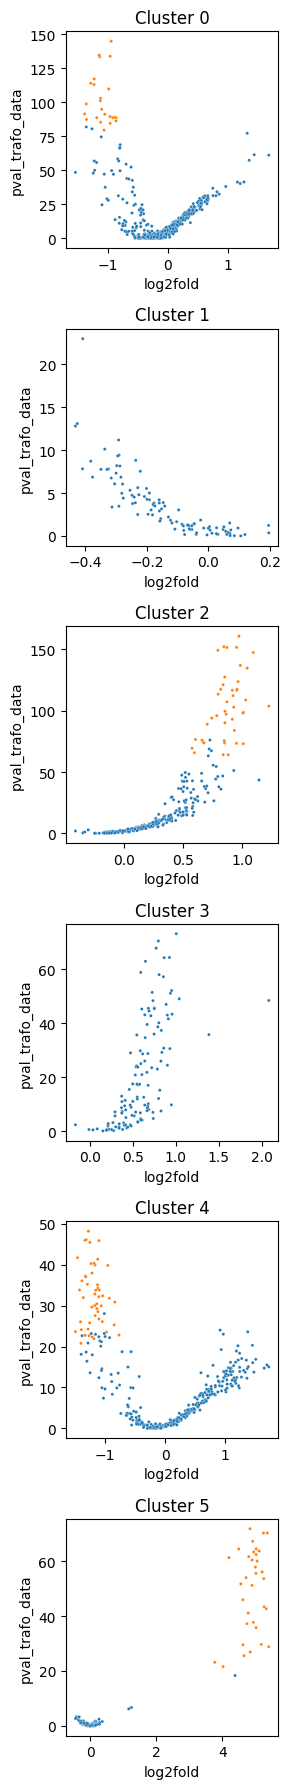

In [10]:
fig, ax = plt.subplots(len(clusters), 1, figsize=(3, 3*len(clusters)))

i=0
for c in clusters:
    pvals_test = data_gene_cluster.uns["ClusterDE_results"][c]

    expr_gene_group_1 = data_gene[data_gene.obs["leiden_opt"] == c].layers["vst_counts"].copy().toarray()
    expr_gene_group_0 = data_gene[data_gene.obs["leiden_opt"] != c].layers["vst_counts"].copy().toarray()

    sum_group_0 = np.log2(np.mean(np.exp(expr_gene_group_0), axis=0) - (data_gene.var["nb_overdisp_cutoff"] / 4) + 1e-9)
    sum_group_1 = np.log2(np.mean(np.exp(expr_gene_group_1), axis=0) - (data_gene.var["nb_overdisp_cutoff"] / 4) + 1e-9)
    lfc = sum_group_1 - sum_group_0
    
    pvals_test["log2fold"] = lfc
    pvals_test["is_de"] = (pvals_test["q"] <= 0.05)
    pvals_test["log_q"] = -np.log10(pvals_test["q"])

    perc_zero_clust = (np.sum(data_gene_cluster[data_gene_cluster.obs["leiden_opt"] == c].layers["counts"].toarray() == 0, axis=0))/(data_gene_cluster[data_gene_cluster.obs["leiden_opt"] == c].shape[0])
    percent_zeros = pd.DataFrame({"perc_zero": perc_zero_clust}, index=data_gene_cluster.var_names)
    pvals_test["percent_zero"] = percent_zeros["perc_zero"]

    sns.scatterplot(pvals_test[pvals_test["percent_zero"] <= 0.5], x="log2fold", y="pval_trafo_data", hue="is_de", alpha=1, s=5, ax=ax[i])
    ax[i].set_title(f"Cluster {c}")
    ax[i].get_legend().remove()
    i += 1
    
plt.tight_layout()

plt.savefig(f"{figure_path}/{dataset_name}_summary_figure.svg", format="svg")
plt.savefig(f"{figure_path}/{dataset_name}_summary_figure.png", format="png", dpi=300)

plt.show()


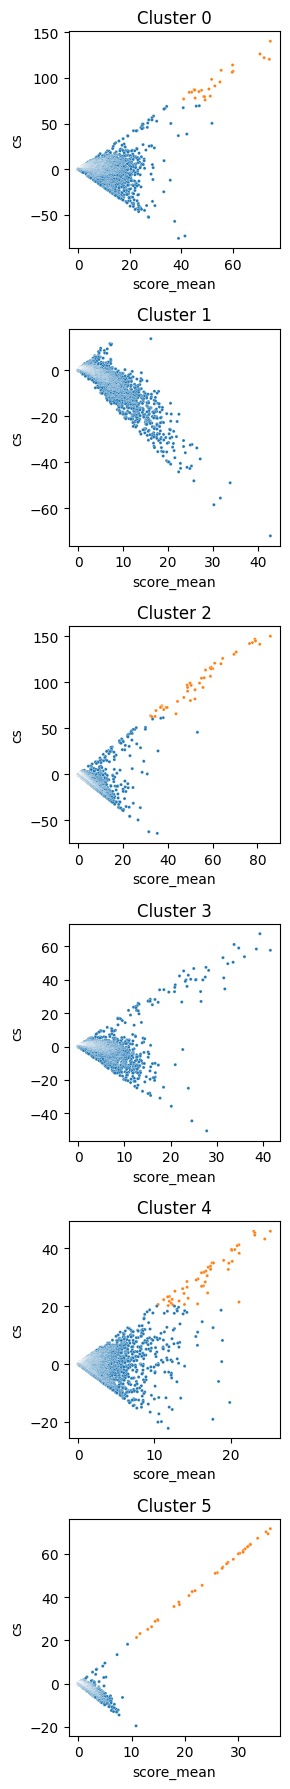

In [11]:
fig, ax = plt.subplots(len(clusters), 1, figsize=(3, 3*len(clusters)))

i = 0
for c in clusters:
    pvals_test = data_gene_cluster.uns["ClusterDE_results"][c]

    pvals_test["score_mean"] = (pvals_test["pval_trafo_data"] + pvals_test["pval_trafo_null"])/2
    pvals_test["is_de"] = (pvals_test["q"] <= 0.05)

    sns.scatterplot(pvals_test, x="score_mean", y="cs", hue="is_de", alpha=1, s=5, ax=ax[i])
    ax[i].set_title(f"Cluster {c}")
    ax[i].get_legend().remove()    
    i += 1

plt.tight_layout()
plt.savefig(figure_path + "/volcano_clusterde.svg", format="svg")

plt.show()

## scCODA

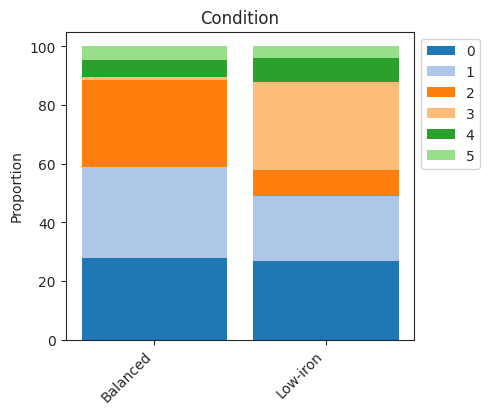

In [124]:
import pertpy as pt
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    data_gene,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden_opt",
    sample_identifier=["Condition"],
)
sccoda_data["coda"].obs["Condition"] = sccoda_data["coda"].obs.index

sccoda_model.plot_stacked_barplot(data=sccoda_data, modality_key="coda", feature_name="Condition", figsize=(4.5,4))
plt.savefig(figure_path + "/stackbar.png", format="png", bbox_inches='tight', dpi=300)
plt.show()

In [118]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="Condition",
    reference_cell_type="automatic",
)

sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=3456)
sccoda_data["coda"]

sccoda_model.set_fdr(sccoda_data, est_fdr=0.2)
sccoda_model.summary(sccoda_data, modality_key="coda", extended=True)


Automatic reference selection! Reference cell type set to 0

sample: 100%|██████████| 11000/11000 [00:13<00:00, 803.87it/s, 79 steps of size 4.40e-02. acc. prob=0.62]  


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 2 samples, 6 cell types                                           │
│ Reference cell type                   │ 0                                                                       │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 0.700                                                                   │
│ Spike-and-slab threshold              │ 0.700                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (1000 burnin samples)                        │
│ Acceptance rate                       │ 61.7%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                                              │
│ Cell Type                                                                                                       │
│ 0              2.673         0.641  4.857   1.184     432.377                                                   │
│ 1              2.653         0.611  4.944   1.216     423.815                                                   │
│ 2              2.459         0.134  4.904   1.367     349.079                                                   │
│ 3              0.182        -1.557  1.847   0.920      35.813                                                   │
│ 4              1.263        -0.719  3.465   1.172     105.562                                                   │
│ 5              0.899        -1.232  2.997   1.173      73.354                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                       Final Parameter  Expected Sample  log2-fold change                                        │
│ Covariate  Cell Type                                                                                            │
│ T.Low-iron 0               0.000          378.468            -0.192                                             │
│            1               0.000          370.973            -0.192                                             │
│            2              -0.893          125.118            -1.480                                             │
│            3               2.518          388.832             3.441                                             │
│            4               0.000           92.400            -0.192                                             │
│            5               0.000           64.208            -0.192                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                       HDI 3%  HDI 97%   SD   Inclusion probability                                              │
│ Covariate  Cell Type                                                                                            │
│ T.Low-iron 0           0.000  0.000   0.000         0.000                                                       │
│            1          -1.165  0.626   0.297         0.350                                                       │
│            2          -1.902  0.244   0.651         0.700                                                       │
│            3          -0.104  4.285   1.330         0.920                                                       │
│            4          -0.860  1.657   0.445         0.404                                                       │
│            5          -1.326  1.374   0.424         0.371                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

## copathogenex comparison

In [73]:
px_da = pd.read_csv(data_path + "/combined_S2S3/low_iron_analysis.tsv", sep="\t")
sc.tl.rank_genes_groups(data_gene, 'Sample', method='wilcoxon')
px_da.index = px_da["locus_tag"]
dedf = sc.get.rank_genes_groups_df(data_gene, group="S2")
dedf["Wilcoxon"] = dedf["pvals_adj"] < 0.01
dedf.index=dedf["names"]
dedf

names     scores  logfoldchanges          pvals      pvals_adj  \
names                                                                     
PA4514  PA4514  29.418455             NaN  3.189375e-190  1.772336e-186   
PA4370  PA4370  22.473766             NaN  7.495782e-112  2.082703e-108   
PA4675  PA4675  20.636263             NaN   1.297126e-94   2.402710e-91   
PA4515  PA4515  20.410872             NaN   1.338767e-92   1.859882e-89   
PA0969  PA0969  20.266117             NaN   2.560859e-91   2.846139e-88   
...        ...        ...             ...            ...            ...   
PA4429  PA4429  -7.713994             NaN   1.219407e-14   2.710498e-12   
PA1689  PA1689  -7.924431             NaN   2.291935e-15   5.537514e-13   
PA5558  PA5558  -9.000798             NaN   2.240832e-19   5.660139e-17   
PA2071  PA2071 -10.095086             NaN   5.807982e-24   2.151664e-21   
PA3531  PA3531 -16.775068             NaN   3.714369e-63   2.948678e-60   

        Wilcoxon  
names             
PA4514      True  
PA4370      True  
PA4675      True  
PA4515      True  
PA0969      True  
...          ...  
PA4429      True  
PA1689      True  
PA5558      True  
PA2071      True  
PA3531      True  

[5557 rows x 6 columns]

In [74]:
total_compare = pd.merge(px_da, dedf, left_index=True, right_index=True, how="outer")
total_compare[["copathogenex", "logistic_regression", "differential_expression"]] = total_compare[["copathogenex", "logistic_regression", "differential_expression"]].fillna(False)
total_compare = total_compare.sort_values("pvals_adj", ascending=True)
total_compare["Wilcoxon_rank"] = np.arange(len(total_compare)) + 1
total_compare

locus_tag  copathogenex  logistic_regression  differential_expression  \
PA4514    PA4514         False                 True                     True   
PA4370    PA4370          True                False                    False   
PA4675       NaN         False                False                    False   
PA4515    PA4515          True                 True                     True   
PA0969       NaN         False                False                    False   
...          ...           ...                  ...                      ...   
PA2479       NaN         False                False                    False   
PA2788       NaN         False                False                    False   
PA4308       NaN         False                False                    False   
PA0748    PA0748         False                False                     True   
PA1029    PA1029         False                False                     True   

                                                     Name Genes PGFam   names  \
PA4514             iron transport outer membrane receptor   NaN   NaN  PA4514   
PA4370  insulin-cleaving metalloproteinase outer membr...   NaN   NaN  PA4370   
PA4675                                                NaN   NaN   NaN  PA4675   
PA4515                                        hydroxylase   NaN   NaN  PA4515   
PA0969                                                NaN   NaN   NaN  PA0969   
...                                                   ...   ...   ...     ...   
PA2479                                                NaN   NaN   NaN  PA2479   
PA2788                                                NaN   NaN   NaN  PA2788   
PA4308                                                NaN   NaN   NaN  PA4308   
PA0748                               uncharacterized gene   NaN   NaN     NaN   
PA1029                               uncharacterized gene   NaN   NaN     NaN   

           scores  logfoldchanges          pvals      pvals_adj Wilcoxon  \
PA4514  29.418455             NaN  3.189375e-190  1.772336e-186     True   
PA4370  22.473766             NaN  7.495782e-112  2.082703e-108     True   
PA4675  20.636263             NaN   1.297126e-94   2.402710e-91     True   
PA4515  20.410872             NaN   1.338767e-92   1.859882e-89     True   
PA0969  20.266117             NaN   2.560859e-91   2.846139e-88     True   
...           ...             ...            ...            ...      ...   
PA2479  -0.301726             NaN   7.628610e-01   9.998312e-01    False   
PA2788  -0.487938             NaN   6.255938e-01   9.998312e-01    False   
PA4308   0.000023             NaN   9.999816e-01   9.999816e-01    False   
PA0748        NaN             NaN            NaN            NaN      NaN   
PA1029        NaN             NaN            NaN            NaN      NaN   

        Wilcoxon_rank  
PA4514              1  
PA4370              2  
PA4675              3  
PA4515              4  
PA0969              5  
...               ...  
PA2479           5555  
PA2788           5556  
PA4308           5557  
PA0748           5558  
PA1029           5559  

[5559 rows x 14 columns]

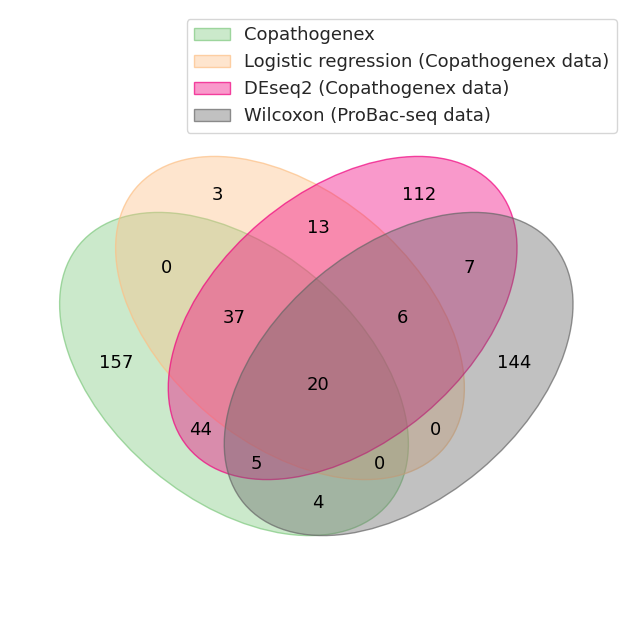

In [91]:
import venn


res_dict = {
    "Copathogenex": set(total_compare[total_compare["copathogenex"] == True]["names"].tolist()),
    "Logistic regression (Copathogenex data)": set(total_compare[total_compare["logistic_regression"] == True]["names"].tolist()),
    "DEseq2 (Copathogenex data)": set(total_compare[total_compare["differential_expression"] == True]["names"].tolist()),
    "Wilcoxon (ProBac-seq data)": set(total_compare[total_compare["Wilcoxon"] == True]["names"].tolist()),

}
venn.venn(res_dict, cmap="Accent")
plt.show()

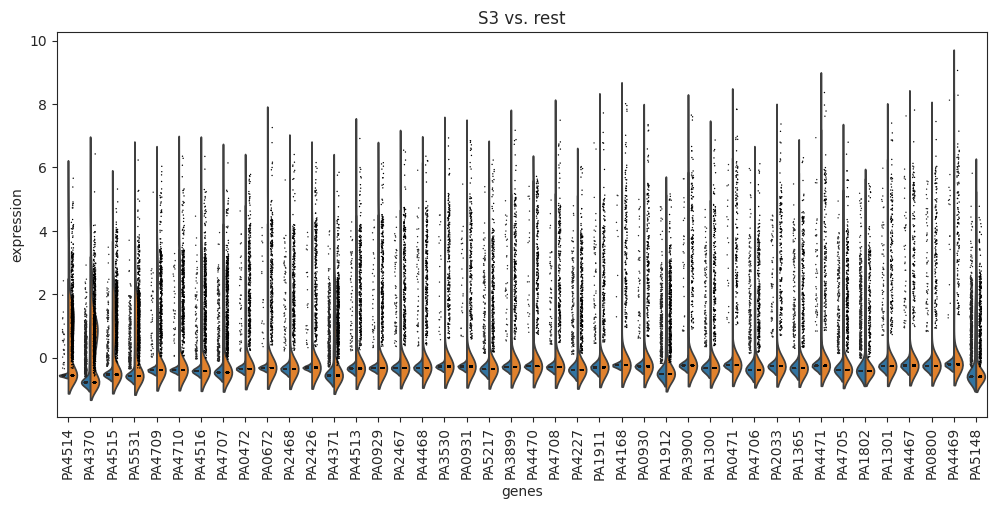

In [80]:
genes_de = total_compare[
    ((total_compare["copathogenex"] == True) |
    (total_compare["logistic_regression"] == True) |
    (total_compare["differential_expression"] == True)) &
    (total_compare["Wilcoxon"] == True)
    ].index.tolist()

with plt.rc_context({"figure.figsize": (12, 5)}):
    sc.pl.rank_genes_groups_violin(data_gene, gene_names=genes_de, groups="S3")

In [82]:
overlap_df = total_compare.loc[genes_de, ["Name", "PGFam", "Wilcoxon_rank"]]
print(overlap_df.to_latex())

\begin{tabular}{lllr}
\toprule
{} &                                               Name &                                              PGFam &  Wilcoxon\_rank \\
\midrule
PA4514 &             iron transport outer membrane receptor &                                                NaN &              1 \\
PA4370 &  insulin-cleaving metalloproteinase outer membr... &                                                NaN &              2 \\
PA4515 &                                        hydroxylase &                                                NaN &              4 \\
PA5531 &                                   transporter TonB &                                                NaN &              6 \\
PA4709 &                             hemin degrading factor &                                                NaN &              9 \\
PA4710 &  heme/hemoglobin uptake outer membrane receptor... &                                                NaN &             10 \\
PA4516 &                        

## Combine subplots into one big figure

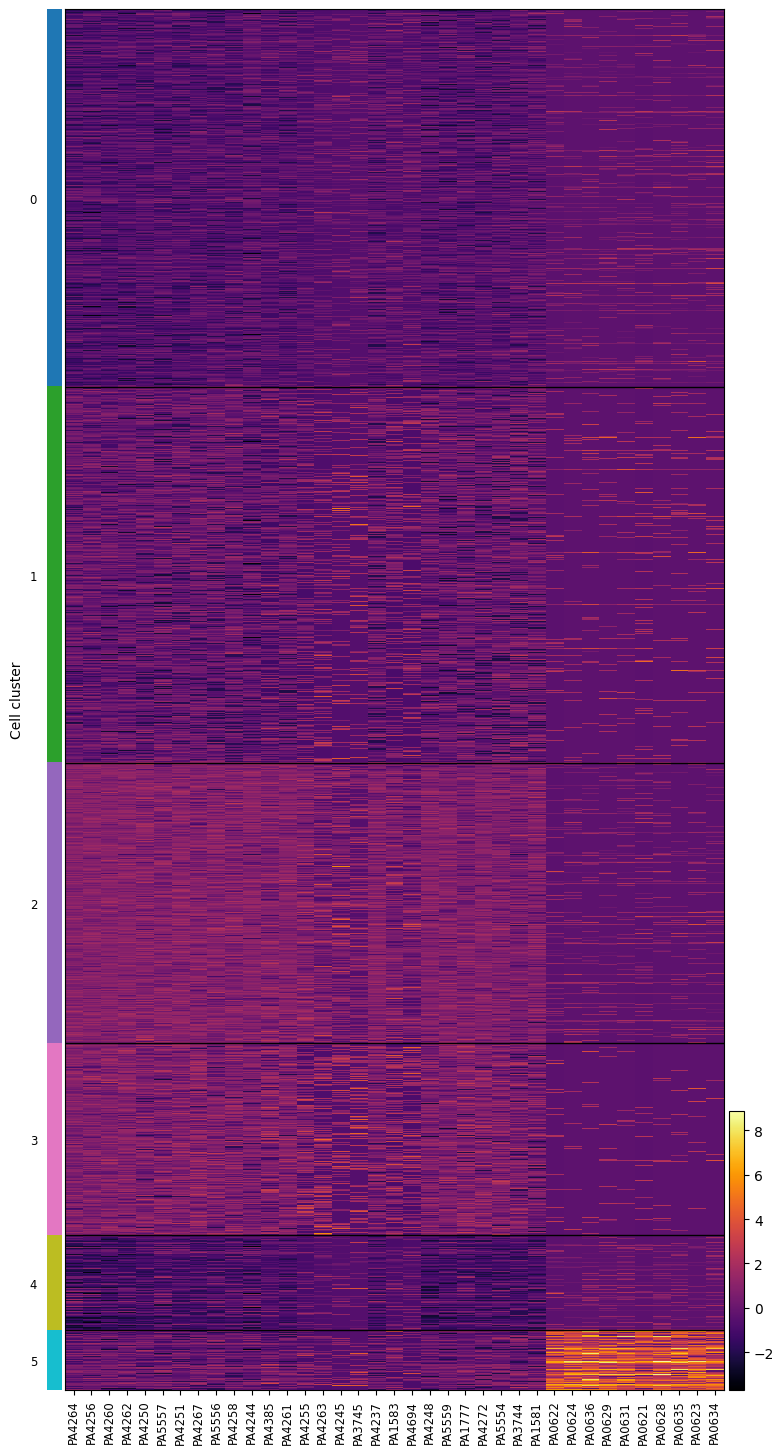

In [12]:
n_genes = 10
clusters = data_gene.obs["leiden_opt"].unique().tolist()
clusters.sort()
n_clusters = len(clusters)

all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    
all_marker_genes = list(dict.fromkeys(all_marker_genes))
heatmap_plot = sc.pl.heatmap(data_gene_cluster, all_marker_genes, groupby='leiden_opt', swap_axes=False, show_gene_labels=True, show=False, cmap="inferno", figsize=(9, 3*n_clusters))
heatmap_plot["groupby_ax"].set(ylabel="Cell cluster")
plt.tight_layout()
plt.savefig(figure_path + "/heatmap_temp.png", format="png", bbox_inches='tight', dpi=300)

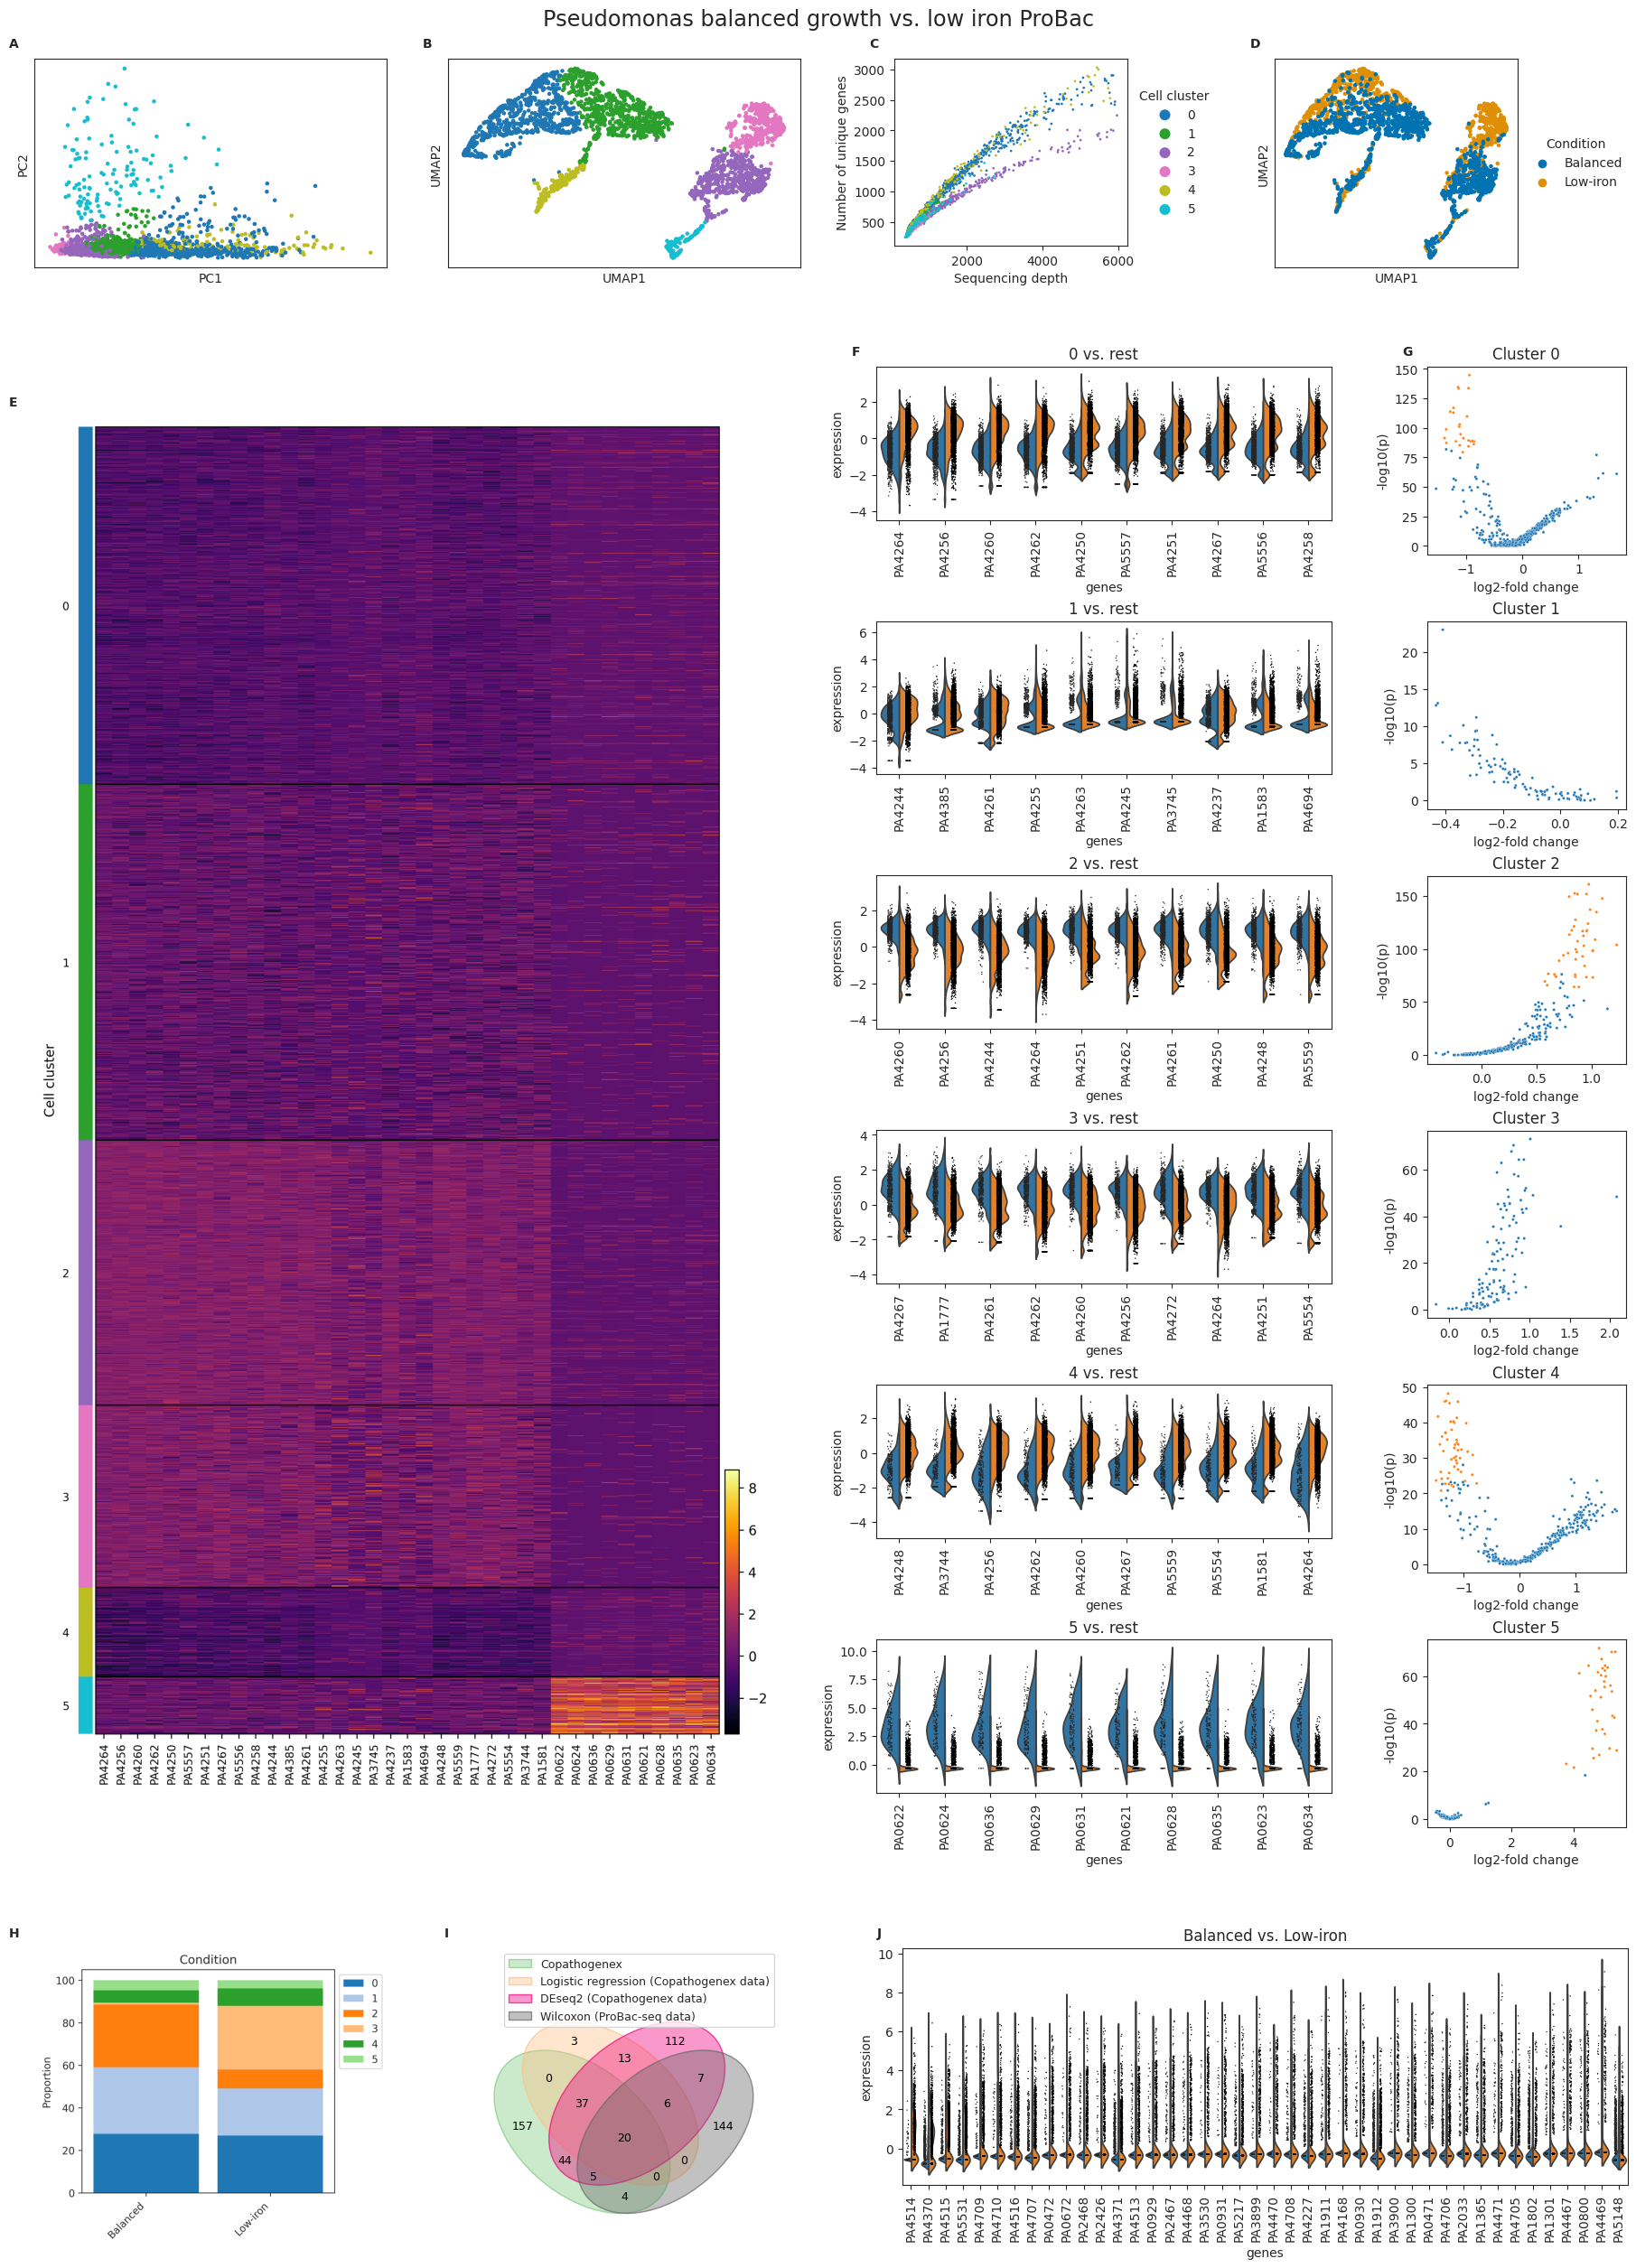

In [126]:
import matplotlib.transforms as mtransforms

# gridspec inside gridspec

fig = plt.figure(layout='constrained', figsize=(18, 3*(n_clusters + 2)+1))
subfigs = fig.subfigures(3, 1, hspace=0.07, height_ratios=[3, n_clusters*3, 4])
subfigsTop = subfigs[0].subfigures(1, 4, wspace=0.07)

ax_pca = subfigsTop[0].subplots(1,1)
sc.pl.pca(data_gene, color="leiden_opt", show=False, ax=ax_pca, title="", legend_loc=None)

ax_umap_cluster = subfigsTop[1].subplots(1,1)
sc.pl.umap(data_gene, color="leiden_opt", show=False, palette="tab10", ax=ax_umap_cluster, title="", legend_loc=None)

ax_scatter = subfigsTop[2].subplots(1,1)
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt", palette="tab10", ax=ax_scatter, title="")
ax_scatter.set(xlabel="Sequencing depth", ylabel="Number of unique genes")
ax_scatter.legend_.set_title("Cell cluster")

ax_umap_seqdepth = subfigsTop[3].subplots(1,1) 
pal = [sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[1]]
sc.pl.umap(data_gene, color="Condition", show=False, palette=pal, title="", ax=ax_umap_seqdepth)
ax_umap_seqdepth.legend_.set_title("Condition")

subfigsBot = subfigs[1].subfigures(1, 3, wspace=0.07, width_ratios=[0.5, 1/3, 1/6])

all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes

heatmap_ax = subfigsBot[0].subplots(1, 1)

img = mpimg.imread(figure_path + "/heatmap_temp.png")
heatmap_ax.imshow(img)
heatmap_ax.axis('off')

axs_violin = subfigsBot[1].subplots(n_clusters, 1)

i = 0
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_cluster, gene_names=plot_genes, key="ClusterDE_results", groups=c, ax=axs_violin[i], show=False)
    
    i += 1

    
sc.tl.rank_genes_groups(data_gene_cluster, "leiden_opt", method="wilcoxon", layer="vst_counts")

axs_volcano = subfigsBot[2].subplots(n_clusters, 1)

i=0
for c in clusters:
    pvals_test = data_gene_cluster.uns["ClusterDE_results"][c]

    expr_gene_group_1 = data_gene[data_gene.obs["leiden_opt"] == c].layers["vst_counts"].copy().toarray()
    expr_gene_group_0 = data_gene[data_gene.obs["leiden_opt"] != c].layers["vst_counts"].copy().toarray()

    sum_group_0 = np.log2(np.mean(np.exp(expr_gene_group_0), axis=0) - (data_gene.var["nb_overdisp_cutoff"] / 4) + 1e-9)
    sum_group_1 = np.log2(np.mean(np.exp(expr_gene_group_1), axis=0) - (data_gene.var["nb_overdisp_cutoff"] / 4) + 1e-9)
    lfc = sum_group_1 - sum_group_0
    
    pvals_test["log2fold"] = lfc
    pvals_test["is_de"] = (pvals_test["q"] <= 0.05)

    perc_zero_clust = (np.sum(data_gene_cluster[data_gene_cluster.obs["leiden_opt"] == c].layers["counts"].toarray() == 0, axis=0))/(data_gene_cluster[data_gene_cluster.obs["leiden_opt"] == c].shape[0])
    percent_zeros = pd.DataFrame({"perc_zero": perc_zero_clust}, index=data_gene_cluster.var_names)
    pvals_test["percent_zero"] = percent_zeros["perc_zero"]

    sns.scatterplot(pvals_test[pvals_test["percent_zero"] <= 0.5], x="log2fold", y="pval_trafo_data", hue="is_de", alpha=1, s=5, ax=axs_volcano[i])
    axs_volcano[i].set_title(f"Cluster {c}")
    axs_volcano[i].get_legend().remove()
    axs_volcano[i].set(xlabel="log2-fold change", ylabel="-log10(p)")
    i += 1
    
subfigsCond = subfigs[2].subfigures(1, 3, wspace=0.07, width_ratios=[1, 1, 2])

ax_stackbar = subfigsCond[0].subplots(1,1)
img = mpimg.imread(figure_path + "/stackbar.png")
ax_stackbar.imshow(img)
ax_stackbar.axis('off')

ax_venn = subfigsCond[1].subplots(1,1)
res_dict = {
    "Copathogenex": set(total_compare[total_compare["copathogenex"] == True]["names"].tolist()),
    "Logistic regression (Copathogenex data)": set(total_compare[total_compare["logistic_regression"] == True]["names"].tolist()),
    "DEseq2 (Copathogenex data)": set(total_compare[total_compare["differential_expression"] == True]["names"].tolist()),
    "Wilcoxon (ProBac-seq data)": set(total_compare[total_compare["Wilcoxon"] == True]["names"].tolist()),

}
venn.venn(res_dict, cmap="Accent", ax=ax_venn, fontsize=9)

ax_cond_violin = subfigsCond[2].subplots(1,1)
genes_de = total_compare[
    ((total_compare["copathogenex"] == True) |
    (total_compare["logistic_regression"] == True) |
    (total_compare["differential_expression"] == True)) &
    (total_compare["Wilcoxon"] == True)
    ].index.tolist()
sc.pl.rank_genes_groups_violin(data_gene, gene_names=genes_de, groups="S3", ax=ax_cond_violin, show=False)
ax_cond_violin.set(title="Balanced vs. Low-iron")
    
axes = [ax_pca, ax_umap_cluster, ax_scatter, ax_umap_seqdepth, heatmap_ax, axs_violin, axs_volcano, ax_stackbar, ax_venn, ax_cond_violin]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]

for ax, label in zip(axes, labels):
    if type(ax) == np.ndarray:
        ax = ax[0]
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontweight="bold")

fig.suptitle('Pseudomonas balanced growth vs. low iron ProBac', fontsize='xx-large')

plt.savefig(f"{figure_path}/{dataset_name}_summary_figure.svg", format="svg")
plt.savefig(f"{figure_path}/{dataset_name}_summary_figure.png", format="png", dpi=300)

plt.show()

## Technical summary figure

### scTransform Theta parameters

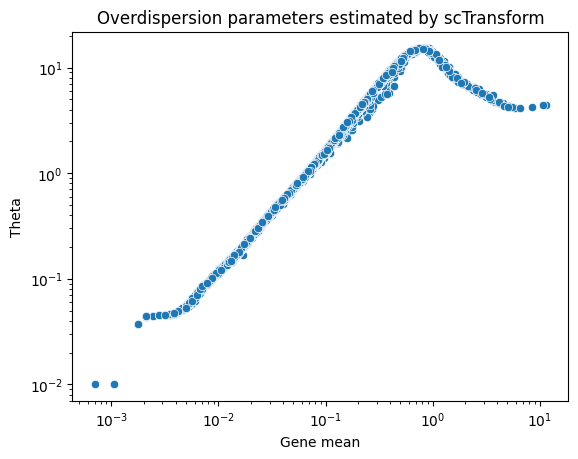

In [14]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

### Sequencing depth distribution before and after VST

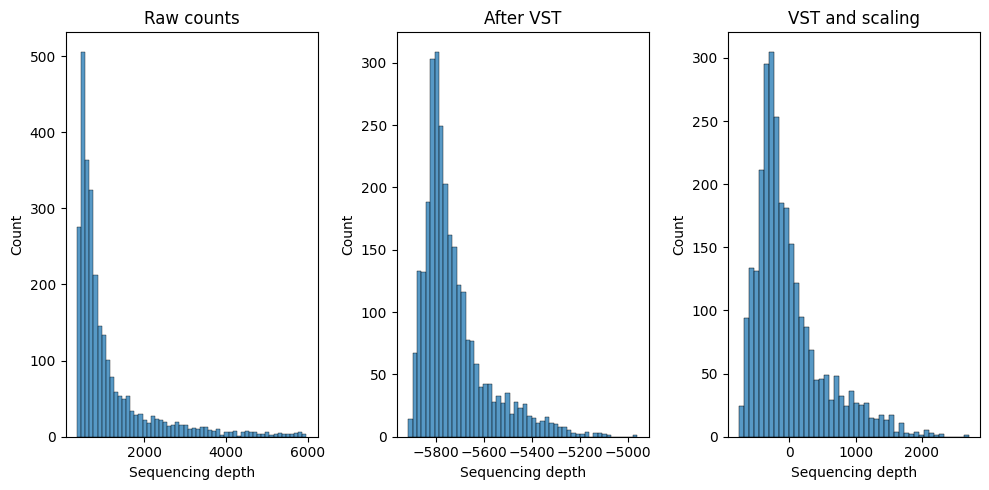

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Raw counts")
axes[0].set(xlabel="Sequencing depth")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("After VST")
axes[1].set(xlabel="Sequencing depth")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaling")
axes[2].set(xlabel="Sequencing depth")
plt.tight_layout()
plt.show()

### Latent dimensionality

In [16]:
k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]

In [17]:
is_overdispersed = False
data_dist = "NB"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)

# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")



Optimal number of PCs:4


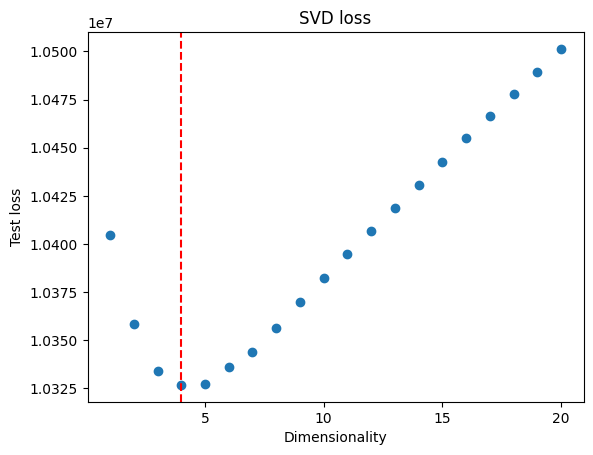

In [18]:
fig, ax = plt.subplots()
ax.scatter(np.arange(20) + 1, k_errors)
ax.set_title("SVD loss")
ax.set(xlabel="Dimensionality", ylabel="Test loss")
ax.set_xticks([5, 10, 15, 20])
plt.axvline(x=k_opt, color="red", linestyle="dashed")
plt.show()

### scDEED results

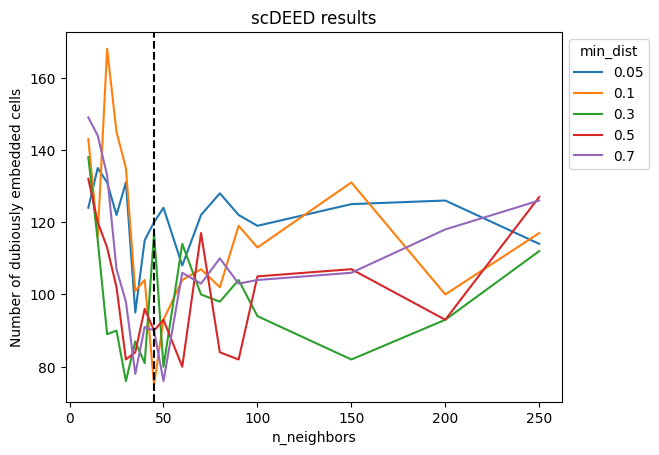

In [19]:
param_df = pd.DataFrame({
    "n_neighbors": [x[0] for x in rel_scores.keys()],
    "min_dist": [x[1] for x in rel_scores.keys()],
    "mean_rel": [np.mean(x) for x in rel_scores.values()],
    "mean_null_rel": [np.mean(x) for x in null_rel_scores.values()],
    "num_dubious": [np.sum([y == "dubious" for y in x]) for x in reliabilities.values()],
    "num_trustworthy": [np.sum([y == "trustworthy" for y in x]) for x in reliabilities.values()],

})
n, p = data_gene.X.shape

param_df["share_dubious"] = param_df["num_dubious"] / n
param_df["share_trustworthy"] = param_df["num_trustworthy"] / n

fig, ax = plt.subplots()
sns.lineplot(data=param_df, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10", ax=ax)
ax.set(title="scDEED results", ylabel="Number of dubiously embedded cells")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.legend_.set_title("min_dist")
plt.axvline(x=n_neighbors_opt, color="black", linestyle="dashed")
plt.show()

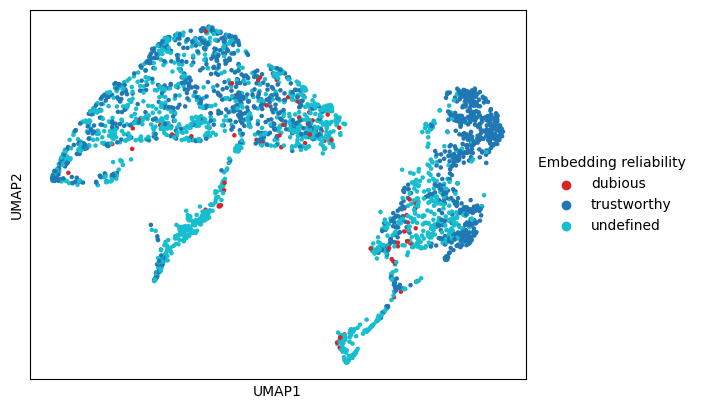

In [20]:
umap_reliability = sc.pl.umap(data_gene, color="embedding_reliability", alpha=1, title="", show=False, 
                              palette={"undefined": "tab:cyan", "trustworthy": "tab:blue", "dubious": "tab:red"}
                             )
umap_reliability.axes.legend_.set_title("Embedding reliability")
plt.show()

### Clustering resolution

In [21]:
mod_df

Unnamed: 0  resolution  n_clusters    type     score
0            0        0.01           1   train  0.490000
1            1        0.01           1    test  0.490000
2            2        0.01           1  random  0.490000
3            3        0.03           1   train  0.470000
4            4        0.03           1    test  0.470000
..         ...         ...         ...     ...       ...
70          70        0.47           7    test  0.265232
71          71        0.47           7  random  0.005344
72          72        0.49           8   train  0.359465
73          73        0.49           8    test  0.252855
74          74        0.49           8  random  0.001074

[75 rows x 5 columns]

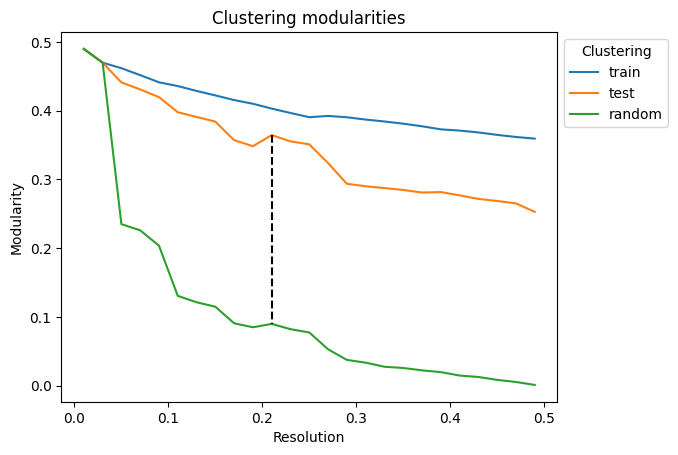

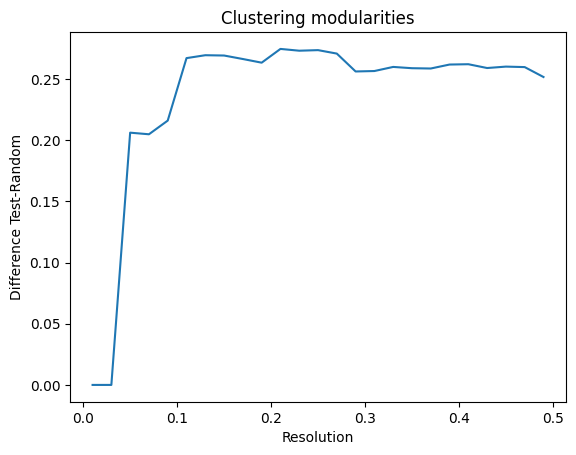

In [22]:
fig, ax = plt.subplots()
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type", ax=ax)
ax.set(title="Clustering modularities", xlabel="Resolution", ylabel="Modularity")
ax.plot(
    [res_opt, res_opt], 
    [mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "test")]["score"],
      mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "random")]["score"]],
    linestyle="dashed", color="black"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.legend_.set_title("Clustering")
plt.show()

sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

### Combine plots

In [23]:
data_null_gen.obs

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
0                   749                 6.620073        1062.0   
1                  1339                 7.200425        2166.0   
2                   813                 6.701960        1132.0   
3                   985                 6.893656        1349.0   
4                   562                 6.333280         850.0   
...                 ...                      ...           ...   
5675                425                 6.054439         550.0   
5676               1049                 6.956545        1693.0   
5677                640                 6.463029         974.0   
5678                823                 6.714171        1095.0   
5679                898                 6.801283        1439.0   

      log1p_total_counts  
0               6.968850  
1               7.681099  
2               7.032624  
3               7.207860  
4               6.746412  
...                  ...  
5675            6.311735  
5676            7.434848  
5677            6.882437  
5678            6.999422  
5679            7.272398  

[5680 rows x 4 columns]

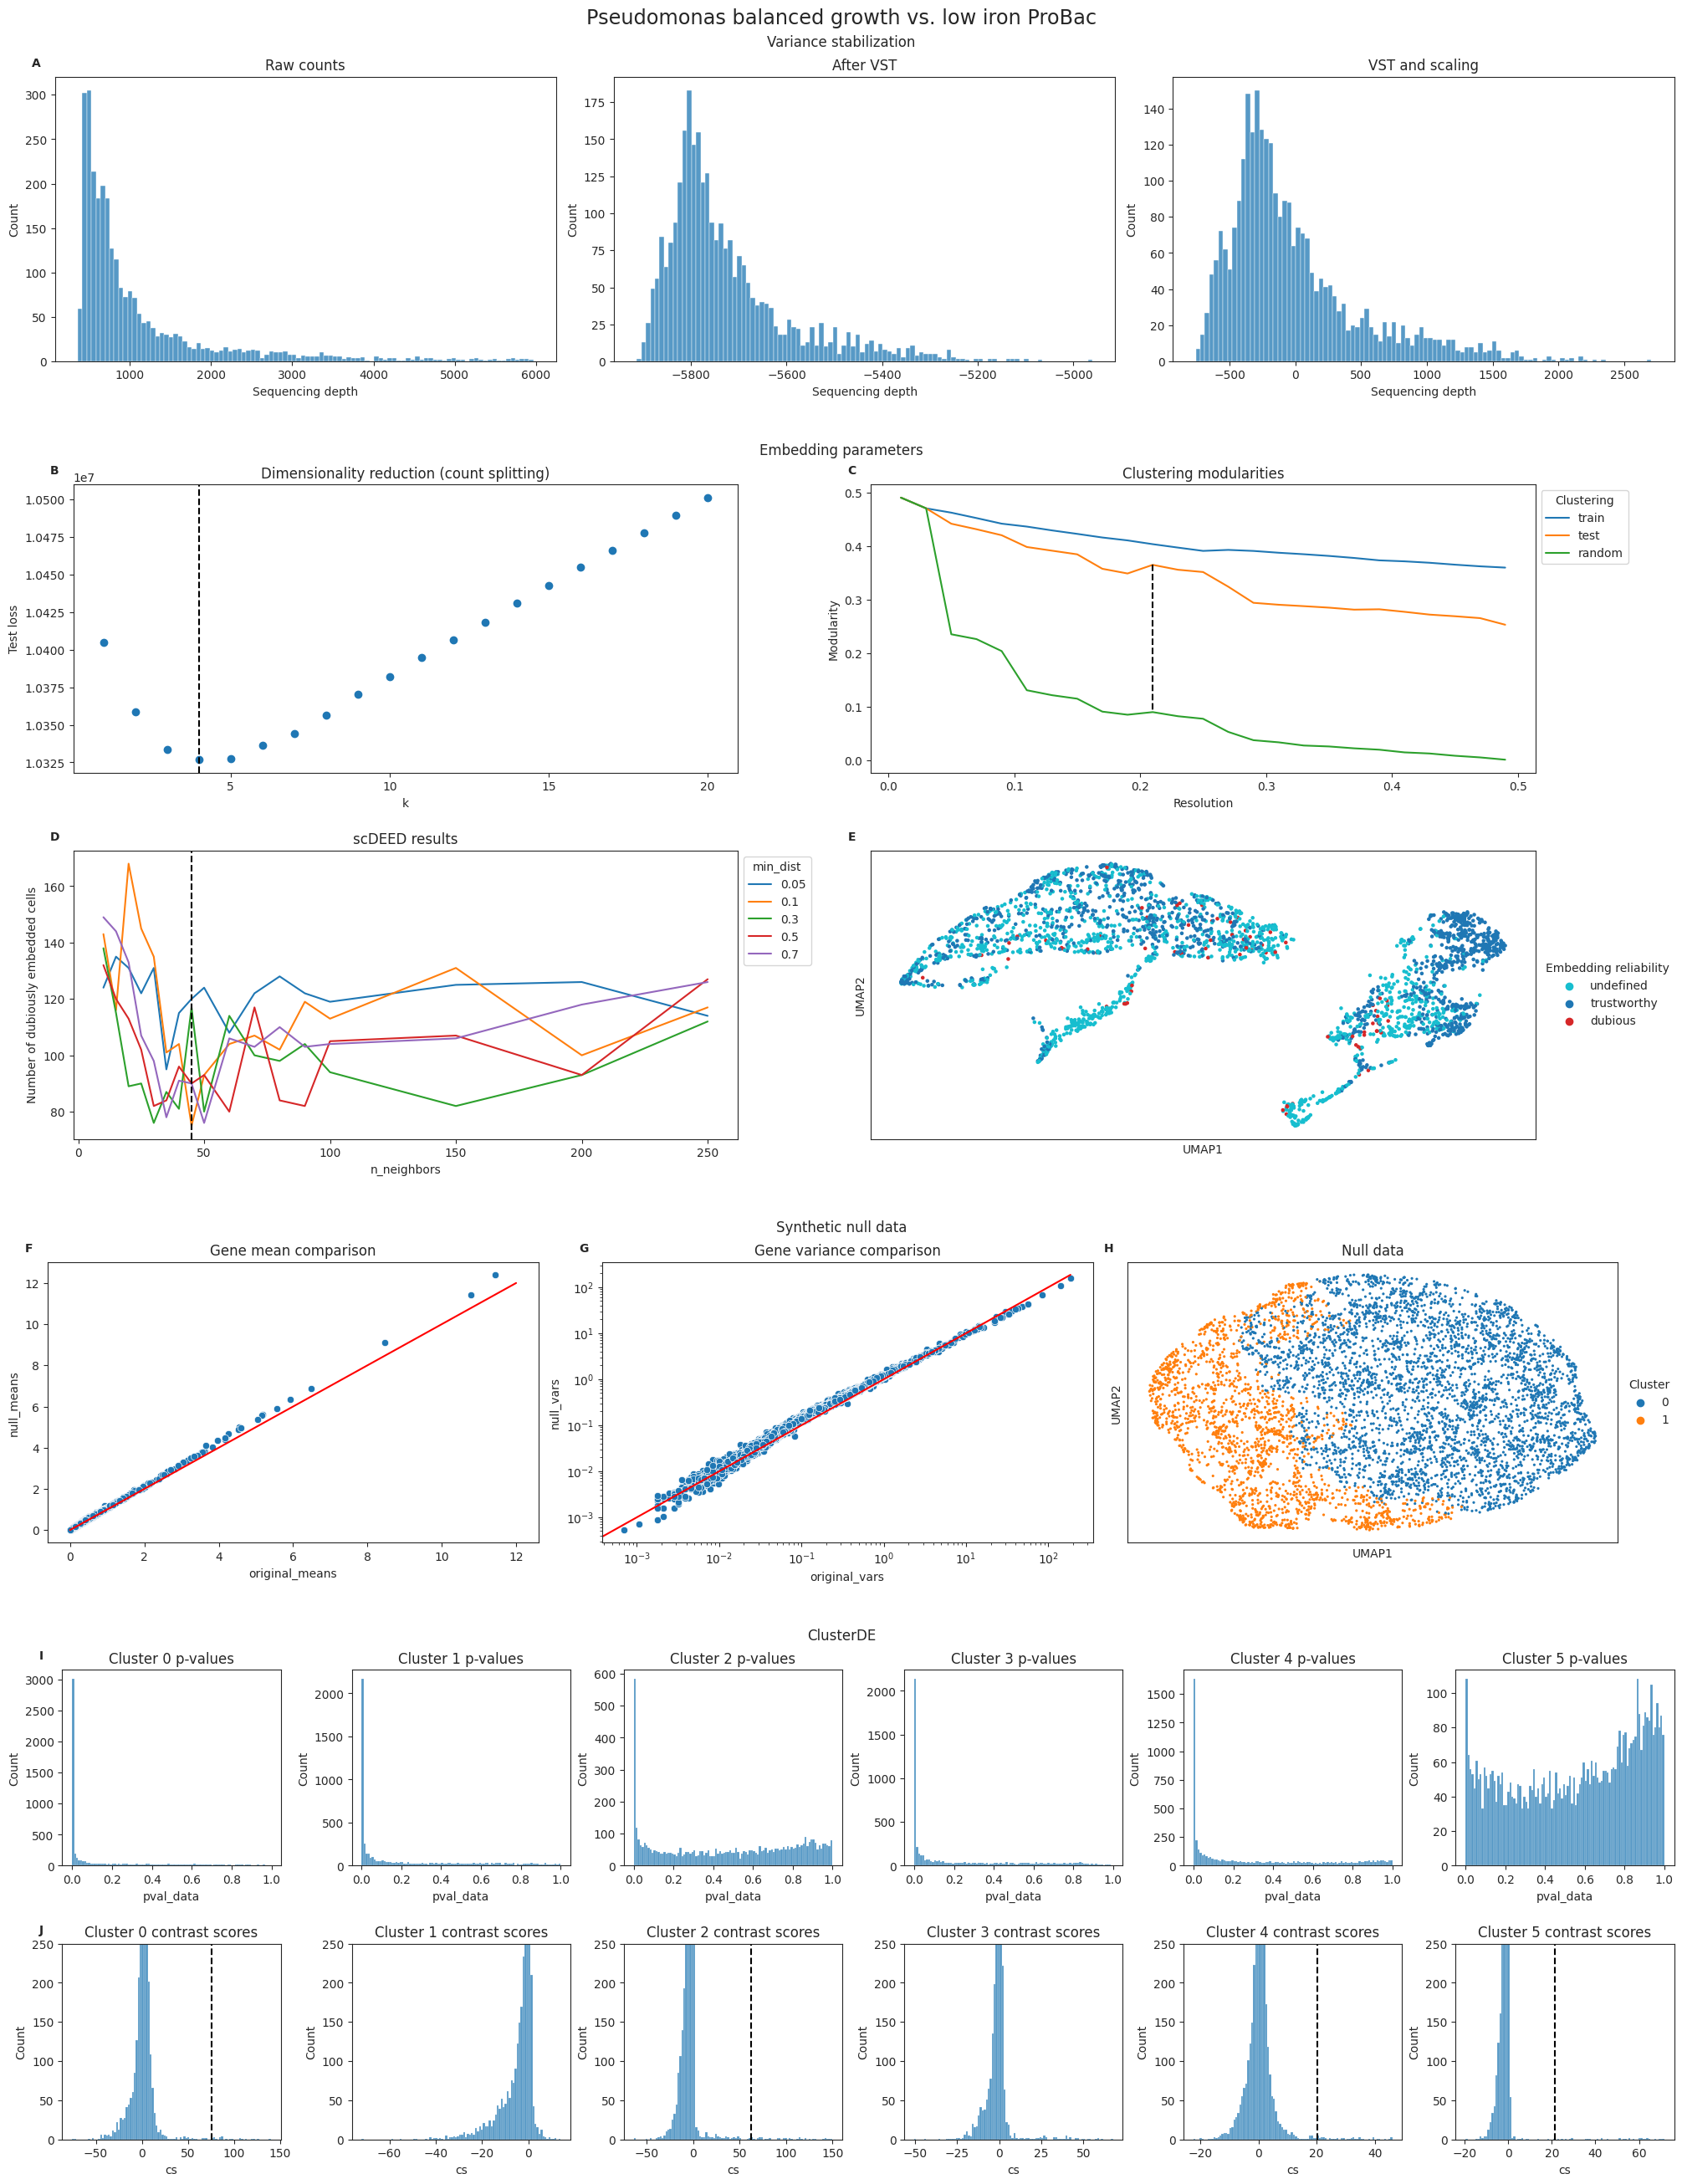

In [83]:
fig = plt.figure(layout='constrained', figsize=(20, 26))
subfigs = fig.subfigures(4, 1, hspace=0.07, height_ratios=[1, 2, 1, 1.5])

subfigs_vst = subfigs[0].subplots(1, 3)

p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=subfigs_vst[0], multiple="stack", bins=100)
subfigs_vst[0].set_title("Raw counts")
subfigs_vst[0].set(xlabel="Sequencing depth")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=subfigs_vst[1], multiple="stack", bins=100)
subfigs_vst[1].set_title("After VST")
subfigs_vst[1].set(xlabel="Sequencing depth")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=subfigs_vst[2], multiple="stack", bins=100)
subfigs_vst[2].set_title("VST and scaling")
subfigs_vst[2].set(xlabel="Sequencing depth")

subfigs[0].suptitle("Variance stabilization")

subfigs_params = subfigs[1].subplots(2,2)

subfigs_params[0,0].scatter(np.arange(20) + 1, k_errors)
subfigs_params[0,0].set_title("Dimensionality reduction (count splitting)")
subfigs_params[0,0].set(xlabel="k", ylabel="Test loss")
subfigs_params[0,0].set_xticks([5, 10, 15, 20])
subfigs_params[0,0].axvline(x=k_opt, color="black", linestyle="dashed")

sns.lineplot(data=param_df, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10", ax=subfigs_params[1,0])
subfigs_params[1,0].set(title="scDEED results", ylabel="Number of dubiously embedded cells")
sns.move_legend(subfigs_params[1,0], "upper left", bbox_to_anchor=(1, 1))
subfigs_params[1,0].legend_.set_title("min_dist")
subfigs_params[1,0].axvline(x=n_neighbors_opt, color="black", linestyle="dashed")

data_gene.obs["embedding_reliability"] = data_gene.obs["embedding_reliability"].cat.reorder_categories(['undefined', 'trustworthy', 'dubious'])
cmap = {"undefined": "tab:cyan", "trustworthy": "tab:blue", "dubious": "tab:red"}
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1, title="", show=False, ax=subfigs_params[1,1], palette=cmap)
subfigs_params[1,1].legend_.set_title("Embedding reliability")

sns.lineplot(data=mod_df, x="resolution", y="score", hue="type", ax=subfigs_params[0,1])
subfigs_params[0,1].set(title="Clustering modularities", xlabel="Resolution", ylabel="Modularity")
subfigs_params[0,1].plot(
    [res_opt, res_opt], 
    [mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "test")]["score"],
      mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "random")]["score"]],
    linestyle="dashed", color="black"
)
sns.move_legend(subfigs_params[0,1], "upper left", bbox_to_anchor=(1, 1))
subfigs_params[0,1].legend_.set_title("Clustering")

subfigs[1].suptitle("Embedding parameters")

subfigs_null_data = subfigs[2].subplots(1, 3)

mean_df_opt = pd.DataFrame({"original_means": data_gene_cluster.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=subfigs_null_data[0])
subfigs_null_data[0].plot([0, np.ceil(np.max(data_gene_cluster.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_cluster.var["mean_counts"]))], color="red")
subfigs_null_data[0].set_title("Gene mean comparison")

var_df_opt = pd.DataFrame({"original_vars": data_gene_cluster.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=subfigs_null_data[1])
g.set(xscale="log", yscale="log")
subfigs_null_data[1].plot([0, np.ceil(np.max(data_gene_cluster.var["var_counts"]))], [0, np.ceil(np.max(data_gene_cluster.var["var_counts"]))], color="red")
subfigs_null_data[1].set_title("Gene variance comparison")

sc.pl.umap(data_null_gen, color="leiden_best", alpha=1, title="Null data", show=False, ax=subfigs_null_data[2])
subfigs_null_data[2].legend_.set_title("Cluster")

subfigs[2].suptitle("Synthetic null data")

pvals_log_gen = data_gene_cluster.uns["ClusterDE_results"]
clusters = data_gene_cluster.obs["leiden_opt"].unique().tolist()
clusters.sort()
n_clusters = len(clusters)
subfigs_clusterde = subfigs[3].subplots(2, n_clusters)

i = 0
for c in clusters:
    sns.histplot(pvals_log_gen[c], x="pval_data", ax=subfigs_clusterde[0,i], bins=100)
    subfigs_clusterde[0,i].set_title(f"Cluster {c} p-values")
    
    sns.histplot(pvals_log_gen[c], x="cs", ax=subfigs_clusterde[1,i], bins=100)
    subfigs_clusterde[1,i].set_title(f"Cluster {c} contrast scores")
    subfigs_clusterde[1,i].set(ylim=(0, 250))
    if np.min(pvals_log_gen[c]["q"]) <= 0.05:
        cutoff = np.min(pvals_log_gen[c][pvals_log_gen[c]["q"] <= 0.05]["cs"])
        subfigs_clusterde[1,i].axvline(x=cutoff, color="black", linestyle="dashed")
    
    i += 1

subfigs[3].suptitle("ClusterDE")

axes = [subfigs_vst, subfigs_params[0,0], subfigs_params[0,1], subfigs_params[1,0], subfigs_params[1,1], subfigs_null_data[0], subfigs_null_data[1], subfigs_null_data[2], subfigs_clusterde[0,0], subfigs_clusterde[1,0]]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]

for ax, label in zip(axes, labels):
    if type(ax) == np.ndarray:
        ax = ax[0]
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontweight="bold")

fig.suptitle('Pseudomonas balanced growth vs. low iron ProBac', fontsize='xx-large')

plt.savefig(f"{figure_path}/{dataset_name}_technical_figure.svg", format="svg")
plt.savefig(f"{figure_path}/{dataset_name}_technical_figure.png", format="png", dpi=300)
plt.show()

## DE table

In [30]:
cde_res = data_gene_cluster.uns["ClusterDE_results"]

In [31]:
cde_res["2"]["q"]

index
PA4260    0.025
PA4256    0.025
PA4244    0.025
PA4264    0.025
PA4251    0.025
          ...  
PA4759    1.000
PA2647    1.000
PA3107    1.000
PA1838    1.000
PA5315    1.000
Name: q, Length: 5557, dtype: float64

In [32]:
clusters = list(cde_res.keys())[:-1]
print(clusters)

cluster_ana_table = pd.DataFrame({
    "Number of cells": [len(data_gene.obs[data_gene.obs["leiden_opt"] == c]) for c in clusters],
    "minimal q": [np.min(cde_res[c]["q"]) for c in clusters],
    "DE genes, FDR = 0.05": [len(cde_res[c][cde_res[c]["q"] < 0.05]) for c in clusters],
    "DE genes, FDR = 0.1": [len(cde_res[c][cde_res[c]["q"] < 0.1]) for c in clusters],
    "DE genes, FDR = 0.2": [len(cde_res[c][cde_res[c]["q"] < 0.2]) for c in clusters],
}, index=pd.Index(clusters, name="Cell Type"))
cluster_ana_table

['0', '1', '2', '3', '4', '5']


Number of cells  minimal q  DE genes, FDR = 0.05  \
Cell Type                                                     
0                      777   0.041667                    24   
1                      773   1.000000                     0   
2                      576   0.025000                    43   
3                      396   0.120000                     0   
4                      194   0.025000                    50   
5                      124   0.029412                    34   

           DE genes, FDR = 0.1  DE genes, FDR = 0.2  
Cell Type                                            
0                           31                   44  
1                            0                    0  
2                           54                   66  
3                            0                   34  
4                           66                   71  
5                           36                   36

In [33]:
print(cluster_ana_table.reset_index().to_latex(index=False))


\begin{tabular}{lrrrrr}
\toprule
Cell Type &  Number of cells &  minimal q &  DE genes, FDR = 0.05 &  DE genes, FDR = 0.1 &  DE genes, FDR = 0.2 \\
\midrule
        0 &              777 &   0.041667 &                    24 &                   31 &                   44 \\
        1 &              773 &   1.000000 &                     0 &                    0 &                    0 \\
        2 &              576 &   0.025000 &                    43 &                   54 &                   66 \\
        3 &              396 &   0.120000 &                     0 &                    0 &                   34 \\
        4 &              194 &   0.025000 &                    50 &                   66 &                   71 \\
        5 &              124 &   0.029412 &                    34 &                   36 &                   36 \\
\bottomrule
\end{tabular}



In [34]:
all_marker_genes = []
for c in clusters:
    print(f"Cluster {c}")
    for g in data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist():
        print(f"{g}: {data_gene.var.loc[g]['Name']}")
    print("")

Cluster 0
PA4264: 30S ribosomal protein S10
PA4256: 50S ribosomal protein L16
PA4260: 50S ribosomal protein L2
PA4262: 50S ribosomal protein L4
PA4250: 30S ribosomal protein S14
PA5557: ATP synthase subunit delta
PA4251: 50S ribosomal protein L5
PA4267: 30S ribosomal protein S7
PA5556: ATP synthase subunit alpha
PA4258: 50S ribosomal protein L22

Cluster 1
PA4244: 50S ribosomal protein L15
PA4385: molecular chaperone GroEL
PA4261: 50S ribosomal protein L23
PA4255: 50S ribosomal protein L29
PA4263: 50S ribosomal protein L3
PA4245: 50S ribosomal protein L30
PA3745: 30S ribosomal protein S16
PA4237: 50S ribosomal protein L17
PA1583: succinate dehydrogenase flavoprotein subunit
PA4694: ketol-acid reductoisomerase

Cluster 2
PA4260: 50S ribosomal protein L2
PA4256: 50S ribosomal protein L16
PA4244: 50S ribosomal protein L15
PA4264: 30S ribosomal protein S10
PA4251: 50S ribosomal protein L5
PA4262: 50S ribosomal protein L4
PA4261: 50S ribosomal protein L23
PA4250: 30S ribosomal protein S14
P

## S2 and S3 gene set overlap

In [36]:
data_gene_cluster_S3 = sc.read_h5ad(data_path + "/outs_S3/filtered_data_maxpool_processed_cluster.h5ad")
data_gene_cluster_S2 = sc.read_h5ad(data_path + "/outs_S2/filtered_data_maxpool_processed_cluster.h5ad")


In [38]:
pvals_S3 = data_gene_cluster_S3.uns["ClusterDE_results"]
pvals_S2 = data_gene_cluster_S2.uns["ClusterDE_results"]

In [45]:
cluster_pairs = [("0", "1"), ("1", "0"), ("3", "3")]
de_genes = {}
for c in cluster_pairs:
    de_genes_S3 = pvals_S3[c[0]][pvals_S3[c[0]]["q"] < 0.05].index.tolist()
    de_genes_S2 = pvals_S2[c[1]][pvals_S2[c[1]]["q"] < 0.05].index.tolist()
    de_genes[c] = (de_genes_S3, de_genes_S2)
    
    common_genes = list(set(de_genes_S3) & set(de_genes_S2))
    common_genes.sort()
    all_genes = list(set(de_genes_S3 + de_genes_S2))
    
    print(f"Clusters {c[0]}, {c[1]} - Overlap {len(common_genes)}/{len(all_genes)}: {common_genes}")
    for g in common_genes:
        print(f"{g}: {data_gene.var.loc[g]['Name']}")
    print("")

Clusters 0, 1 - Overlap 0/0: []

Clusters 1, 0 - Overlap 38/95: ['PA1092', 'PA1581', 'PA1586', 'PA1588', 'PA1589', 'PA1787', 'PA3162', 'PA3181', 'PA3656', 'PA4237', 'PA4239', 'PA4240', 'PA4243', 'PA4244', 'PA4248', 'PA4250', 'PA4251', 'PA4255', 'PA4256', 'PA4257', 'PA4260', 'PA4261', 'PA4262', 'PA4264', 'PA4266', 'PA4267', 'PA4272', 'PA4274', 'PA4385', 'PA4889', 'PA4932', 'PA4933', 'PA4934', 'PA5554', 'PA5555', 'PA5557', 'PA5559', 'PA5569']
PA1092: B-type flagellin
PA1581: succinate dehydrogenase subunit C
PA1586: 2-oxoglutarate dehydrogenase complex dihydrolipoyllysine-residue succinyltransferase
PA1588: succinyl-CoA ligase subunit beta
PA1589: succinyl-CoA ligase subunit alpha
PA1787: aconitate hydratase B
PA3162: 30S ribosomal protein S1
PA3181: 2-dehydro-3-deoxy-phosphogluconate aldolase
PA3656: 30S ribosomal protein S2
PA4237: 50S ribosomal protein L17
PA4239: 30S ribosomal protein S4
PA4240: 30S ribosomal protein S11
PA4243: preprotein translocase subunit SecY
PA4244: 50S ribosom